In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.api import AutoReg

from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

from scipy.stats import boxcox

from statsmodels.stats.diagnostic import acorr_ljungbox



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import ExponentialSmoothing

In [19]:
# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

In [20]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# SUAVIZAÇÃO EXPONENCIAL
    - Simple Exp Smoothing: ''A suavização exponencial simples'' é usada quando o processo de série temporal ''carece'' de ''sazonalidade'' e ''tendência''. Isso também é conhecido como suavização exponencial única.
    - Holt: a ''suavização exponencial de Holt'' é um aprimoramento da suavização exponencial simples e é usada quando o processo de série temporal contém ''apenas'' ''tendência'' (mas sem sazonalidade). É referido como suavização exponencial dupla.
    - Suavização exponencial: a ''suavização exponencial de Holt-Winters'' é um aprimoramento da suavização exponencial de Holt e é usada quando o processo de série temporal ""tem"" ""sazonalidade"" e ""tendência"". É referido como suavização exponencial tripla.

# SUAVIZAÇÃO EXPONENCIAL:

    1. smoothing_level: um valor flutuante para o fator de suavização para o nível conhecido como alfa (𝛼𝛼), onde 0 ≤ 𝛼𝛼 ≤ 1.

     2. smoothing_trend: um valor flutuante para o fator de suavização da tendência conhecido como beta (𝛽𝛽), onde 0 ≤ 𝛽𝛽 ≤ 1.

     3. smoothing_seasonal: um valor flutuante para o fator de suavização para a tendência sazonal conhecida como gama (𝛾𝛾), onde 0 ≤ 𝛾𝛾 ≤ 1.

     4. tendência: Uma única escolha de (multiplicativo ou mul), (aditivo ou adicionar) ou Nenhum.

     5. sazonal: Uma única escolha entre (multiplicativo ou mul), (aditivo ou adicionar) ou Nenhum.

     6. season_periods: Toma um valor inteiro representando o período de sazonalidade, por exemplo, 12 se os dados forem mensais ou 4 se as informações forem trimestrais.

     7. damped_trend: Um valor booleano que é True ou False.

     8. use_boxcox: Um valor booleano que é True ou False para determinar se uma transformação Box-Cox deve ser aplicada.

In [21]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [22]:
# Definindo uma lista de parâmetros
trend = ['add', 'mul']

damped = [True, False]

life_ex_comb = combinator([trend, damped]) # Combinando os parâmetros 372/347
life_ex_comb

# Lembre-se de que a maioria das ferramentas e softwares automatizados usará as pontuações AIC e BIC nos bastidores para determinar o melhor modelo:

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [23]:
# Dataset
url1='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv'
url2='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv'

life = pd.read_csv(url1, 
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)

milk = pd.read_csv(url2, 
                   index_col='month', 
                   parse_dates=True)

C:\Users\Pc\AppData\Local\Temp/ipykernel_12732/133277616.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [24]:
# SPLIT: Função para criar train e test data set
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [25]:
test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)

life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [26]:
train = life_train.values.ravel() #dados de treino

y = life_test.values.ravel() #dados de teste

score = {}

for i, (t, dp) in enumerate(life_ex_comb): #combinação de parâmetros
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None) # Objeto do modelo

    model = exp.fit(use_brute=True, optimized=True)     # Fit modelo

    y_hat = model.forecast(len(y)) # Previsão

    # Métricas do modelo
    score[i] = {'trend':t, \
                'damped':dp,\
                'AIC':model.aic,\
                'BIC':model.bic, \
                'AICc':model.aicc, \
                'RMSPE': rmspe(y, y_hat),\
                'RMSE' : rmse(y, y_hat),\
                'MAPE' : mape(y, y_hat),\
                'model': model}

In [27]:
# Função: Melhor modelo para determinado criterio
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [28]:
life_best_model = get_best_model(score, 'AIC')
life_best_model.summary()

Best model: 1 with lowest AIC score: -137.03060180016485


Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Tue, 29 Nov 2022"
Box-Cox:,False,Time:,00:22:41
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621951,alpha,True
smoothing_trend,0.1621951,beta,True


In [29]:
# Função: Crie a função plot_forecast, que usa um objeto de modelo que você treinou, uma posição inicial e os conjuntos de dados de treinamento 
# e teste para criar um gráfico que compara a previsão (valores previstos) com os reais.

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

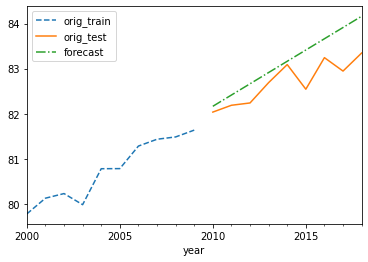

In [30]:
plot_forecast(life_best_model, '2000', life_train, life_test)

# A previsão da suavização exponencial simples produziu uma linha reta estendendo a tendência ascendente dos dados treinados

# Dataset Milk: TAREFA. Considere

trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, 
periods])


In [31]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, 
periods])

In [32]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,\
                'AIC':model.aic,\
                'BIC':model.bic, \
                'AICc': model.aicc,\
                'RMSPE': rmspe(y, y_hat),\
                'RMSE' : rmse(y, y_hat),\
                'MAPE' : mape(y, y_hat),\
                'model': model}

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul


In [33]:
milk_model = get_best_model(milk_model_scores)
milk_model.summary()

Best model: 8 with lowest AIC score: 593.7138896839506


Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Tue, 29 Nov 2022"
Box-Cox:,False,Time:,00:22:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


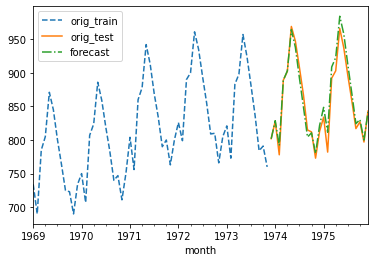

In [34]:
plot_forecast(milk_model, '1969', milk_train, milk_test)

# No geral, o modelo fez um trabalho decente ao capturar o efeito da tendência e da sazonalidade e parecia próximo dos valores reais do conjunto de teste.

# COMPARAÇÃO:
    - O modelo de média móvel trata os valores passados igualmente
    - os modelos do tipo suavização exponencial colocam mais ênfase (peso) nas observações mais recentes. Em outras palavras, observações mais antigas decaem em peso exponencialmente, daí o termo "exponencial". Isso se baseia na suposição lógica de que eventos mais recentes provavelmente serão mais importantes do que eventos muito mais antigos;
        - por exemplo, o que aconteceu ontem ou anteontem é mais relevante do que aconteceu há 2 meses para uma série temporal diária.

# EXTRA

In [37]:
pip install darts


  Using cached darts-0.22.0-py3-none-any.whl (451 kB)
  Using cached pytorch_lightning-1.8.3.post1-py3-none-any.whl (798 kB)
  Using cached tbats-1.1.1-py3-none-any.whl (43 kB)
  Using cached prophet-1.1.1-cp39-cp39-win_amd64.whl (12.1 MB)
  Using cached shap-0.41.0-cp39-cp39-win_amd64.whl (435 kB)
  Using cached lightgbm-3.3.3-py3-none-win_amd64.whl (1.0 MB)
  Using cached holidays-0.17.2-py3-none-any.whl (187 kB)
  Using cached catboost-1.1.1-cp39-none-win_amd64.whl (74.0 MB)
  Using cached nfoursid-1.0.1-py3-none-any.whl (16 kB)
  Using cached statsforecast-1.3.2-py3-none-any.whl (88 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached korean_lunar_calendar-0.3.1-py3-none-any.whl (9.0 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl (10 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached cmdstanpy-1.0.8

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [39]:
#conda install -c conda-forge -c pytorch u8darts-all


^C

Note: you may need to restart the kernel to use updated packages.


In [38]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

# darts espera que os dados sejam uma instância da classe TimeSeries, então você precisa converter seu DataFrame pandas antes de usá-lo 
# para treinar o modelo. A classe TimeSeries fornece o método from_dataframe, que você usará:

ModuleNotFoundError: No module named 'darts'

In [ ]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(),time_col='month', value_cols='production', freq='MS')

In [ ]:
train, test = split_data(ts, 0.15)

model.fit(train)

forecast = model.predict(len(test), num_samples=100)

train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

In [ ]:
model.model.summary() #pag382/357
